# Building a Model to Predict a Winner

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# import the data
data: pd.DataFrame = pd.read_pickle('training_data.pkl'); df = data.copy()
data.head()
print(data.shape, data.columns)

(23703, 49) Index(['tournament_id', 'player_name', 'score', 'Alabama', 'Arizona',
       'California', 'Canada', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Illinois', 'Kentucky', 'Maryland', 'Massachusetts', 'Mexico',
       'Michigan', 'Minnesota', 'Missouri', 'New Jersey', 'New York',
       'North Carolina', 'Ohio', 'Oklahoma', 'Pennsylvania', 'Scotland',
       'South Carolina', 'Tennessee', 'Texas', 'sg_putt', 'sg_arg', 'sg_app',
       'sg_ott', 'sg_t2g', 'sg_total', 'pos', 'putting', 'arg', 'app', 'ott',
       't2g', 'result', 'tournament_putt', 'tournament_arg', 'tournament_app',
       'tournament_ott', 'tournament_t2g', 'tournament_cluster'],
      dtype='object')


In [2]:
## need to update result column
# replace result column with only winners instead of everyone who made the cut
df['result'] = df['pos'].apply(lambda x: 1 if x == '1' else 0)
print(df.result.value_counts())

# now drop pos column
df: pd.DataFrame = df.drop('pos', axis=1)

0    23530
1      173
Name: result, dtype: int64


## First Model

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# splitting data into training and testing data
first = df.copy().dropna(axis=0)
x = first.iloc[:, 3:]
y = x.pop('result')

x, y = x.values, y.values

train_size = round(0.66 * x.shape[0])
shuffle = np.argsort(np.random.random(x.shape[0]))
x, y = x[shuffle], y[shuffle]
xtr, ytr, xte, yte = x[:train_size], y[:train_size], x[train_size:], y[train_size:]

# fitting model
model = RandomForestClassifier(random_state=42)
model.fit(xtr, ytr)
preds: np.array = model.predict(xte)
print(model.score(xte, yte))

cm: np.array = confusion_matrix(yte, preds, normalize="true")
print(cm)

# real accuracy
print(f'real accuracy: {cm[1][1] / sum(cm[1])}')

0.995281847529178
[[9.99625187e-01 3.74812594e-04]
 [7.00000000e-01 3.00000000e-01]]
real accuracy: 0.3


In [4]:
colors = sns.color_palette("mako", as_cmap=True)

def plot_matrix(cm: np.array) -> None:
    # creating heatmap
    heatmap = sns.heatmap(cm, cmap=colors, annot=True, fmt='g')
    labels = ['lose', 'win']

    ## prettifying heatmap
    # adding axis labels
    heatmap.xaxis.set_ticklabels(labels)
    heatmap.yaxis.set_ticklabels(labels)

    # adding titles
    heatmap.set_title('Confusion Matrix with Augmented Data')
    heatmap.set_ylabel('Actual')
    heatmap.set_xlabel('Predicted')

    # showing the plot
    plt.show()

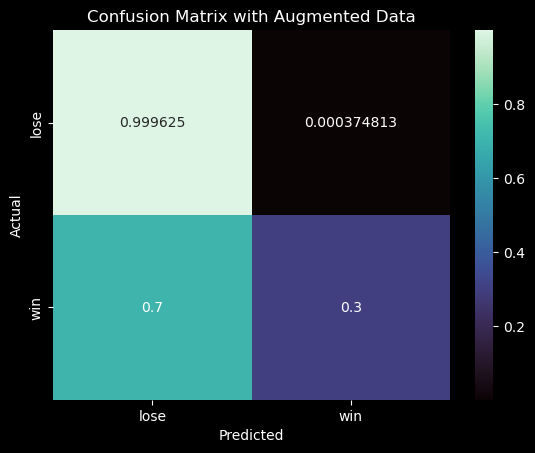

In [5]:
plot_matrix(cm)

## Data Augmentation

In [6]:
data: pd.DataFrame = df[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total', 'result']].copy()

In [7]:
from sklearn.decomposition import PCA

# getting just winners and deciding which columns will be changed by adding normal noise
winners = data.query('result == 1').dropna(axis=0)
to_change = [i for i in range(0, 6)]

## I am going to create two dataframe and join them horizontally
# start by adding noise to the data
pca = PCA()
new_data: pd.DataFrame = winners.copy()
trans = pca.fit_transform(new_data.values)
# print(trans.shape)

above = np.array([])
below = np.array([])
for row in trans:
    noise = np.random.normal(size=11, scale=0.01)
    i = 0
    above_row = np.array([])
    below_row = np.array([])

    for idx, item in enumerate(row):
        if idx in to_change:
            above_row = np.append(above_row, item + noise[i])
            below_row = np.append(below_row, item - noise[i])

            i += 1
        else:
            above_row = np.append(above_row, item)
            below_row = np.append(below_row, item)

    above = np.append(above, above_row)
    below = np.append(below, below_row)

# adding augmented data to orignial winners data
above = pca.inverse_transform(above.reshape(-1, 7))
below = pca.inverse_transform(below.reshape(-1, 7))
winners_improved = np.vstack((winners, above, below))
winners_improved.shape

# adding winners data to non-winners
non_winners = data.query('result == 0').sample(5000).dropna(axis=0).values # sample only 3000 of non winners to make two classes more even
all_data = np.vstack((winners_improved, non_winners))
all_data.shape

(5518, 7)

## Training same model with Augmented Data

In [8]:
# first shuffle and split the data
order = np.argsort(np.random.random(size=all_data.shape[0]))
train_size = int(np.floor(all_data.shape[0] * 0.5))
validation_size = int(np.floor(all_data.shape[0] * 0.75))

shuffled = all_data[order]
shuffled = shuffled[~np.isnan(shuffled)].reshape(-1, 7)
shuffled.shape
train = shuffled[:train_size]
test = shuffled[train_size:validation_size]
validation = shuffled[validation_size:]

# split data up into inputs and labels
xtr, ytr = train[:, :-1], np.round(train[:, -1])
xte, yte = test[:, :-1], np.round(test[:, -1])
xval, yval = validation[:, :-1], np.round(validation[:, -1])

In [9]:
# fitting model with column names
xtr = pd.DataFrame(xtr)
xtr.columns = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

xte = pd.DataFrame(xte)
xte.columns = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

xval = pd.DataFrame(xval)
xval.columns = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

In [10]:
# building model
model2 = RandomForestClassifier(random_state=42)
model2.fit(xtr, ytr)
print(model2.feature_names_in_)
print(model2.score(xte, yte))

# testing model
preds = model2.predict(xte)
cm2 = confusion_matrix(yte, preds)
cm2

['sg_putt' 'sg_arg' 'sg_app' 'sg_ott' 'sg_t2g' 'sg_total']
0.9804205946337926


array([[1223,   21],
       [   6,  129]])

In [11]:
# testing using completely new data
preds_val = model2.predict(xval)
cm3 = confusion_matrix(yval, preds_val, normalize="true")
cm3

array([[0.985623, 0.014377],
       [0.03125 , 0.96875 ]])

In [12]:
# overall score and winner success score
model2.score(xval, yval), 1 - cm3[1][0] / cm3[1].sum()

(0.9840579710144928, 0.96875)

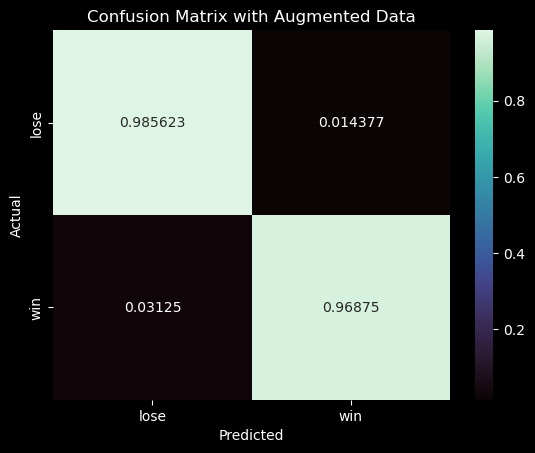

In [13]:
plot_matrix(cm3)

## Getting Baseline

In [14]:
pd.Series(yval).value_counts()

0.0    1252
1.0     128
dtype: int64

## Data Augmentation Worked!!!!

In [15]:
import pickle

# save this model
filename = 'winners_model.sav'
pickle.dump(model2, open(filename, 'wb'))

In [16]:
def make_prediction(model: RandomForestClassifier, data: list, prob: bool = False) -> np.array:
    data_ = pd.DataFrame(data)
    data_.columns = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

    if prob:
        return model.predict_proba(data_)

    else:
        return model.predict(data_)

In [17]:
make_prediction(model2, [[0.49, 0.77, 1.21, 1.58, 3.56, 4.05]])[0]

1.0

In [18]:
make_prediction(model2, [[+1.24,-0.17,+1.18,+0.81,+1.81,+3.05]])[0]

0.0

In [19]:
make_prediction(model2, [[+1.23,-0.37,+1.62,+0.58,+1.82,+3.05]])[0]

0.0

In [20]:
make_prediction(model2, [[+0.84,+0.77,+0.66,+0.53,+1.96,+2.80]])[0]

0.0

In [21]:
make_prediction(model2, [[+0.81,+0.06,+0.73,+0.96,+1.74,+2.55]])[0]

0.0